In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import AR
from scipy import stats
from pandas import to_datetime

def addZero(symbol):#该函数负责将股票代码前面的0补全
    if(len(symbol)==1):
        return "00000"+symbol
    if(len(symbol)==2):
        return "0000"+symbol
    if(len(symbol)==3):
        return "000"+symbol
    if(len(symbol)==4):
        return "00"+symbol
    if(len(symbol)==5):
        return "0"+symbol
    if(len(symbol)==6):
        return symbol
    
def plotsymbol(symbol,x,y):#画出代码为symbol的股票的图，x可以为日期，y可以为营收，利润等
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol][x],Income.loc[Income['TICKER_SYMBOL']==symbol][y])
    
def isContinuous(t):
    if (t.dtype!='datetime64[ns]'):
        raise "t must be 'datetime64[ns]'"
        return
    if t.size==pd.date_range(t.min(),t.max(),freq='Q').size:
        return True
    else:
        return False

Income=pd.read_excel("C:/FDDC_financial_data/FDDC_financial_data/Financial Data/Income Statement.xls",sheet_name="General Business")

In [35]:
print ("处理前的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理前的数据有208133行，68列


In [36]:
#去除唯一值，去除多余的日期选项，只保留一个END_DATE
Income=Income.drop(['PARTY_ID','EXCHANGE_CD','PUBLISH_DATE','END_DATE_REP','FISCAL_PERIOD','MERGED_FLAG'],axis=1)
#去除T_REVENUE,与Revenue高度相关,去除DILUTED_EPS，与basic_eps高度相关
Income=Income.drop(['T_REVENUE','DILUTED_EPS'],axis=1)

In [37]:
#去除空值占比超过50%的值
for col in Income.columns:
    if Income[col].isnull().sum()/Income.shape[0]>0.5:
        Income=Income.drop(col, axis=1)
        print("列%s已经被去除"%col)

列INT_INCOME已经被去除
列PREM_EARNED已经被去除
列COMMIS_INCOME已经被去除
列SPEC_TOR已经被去除
列ATOR已经被去除
列INT_EXP已经被去除
列COMMIS_EXP已经被去除
列PREM_REFUND已经被去除
列N_COMPENS_PAYOUT已经被去除
列RESER_INSUR_CONTR已经被去除
列POLICY_DIV_PAYT已经被去除
列REINSUR_EXP已经被去除
列SPEC_TOC已经被去除
列ATOC已经被去除
列F_VALUE_CHG_GAIN已经被去除
列A_J_INVEST_INCOME已经被去除
列FOREX_GAIN已经被去除
列OTH_EFFECT_OP已经被去除
列ASSETS_DISP_GAIN已经被去除
列AE_EFFECT_OP已经被去除
列OTH_GAIN已经被去除
列OTH_EFFECT_TP已经被去除
列AE_EFFECT_TP已经被去除
列OTH_EFFECT_NP已经被去除
列AE_EFFECT_NP已经被去除
列GOING_CONCERN_NI已经被去除
列QUIT_CONCERN_NI已经被去除
列N_INCOME_BMA已经被去除
列OTH_EFFECT_NPP已经被去除
列AE_EFFECT_NPP已经被去除
列OTH_COMPR_INCOME已经被去除
列OTH_EFFECT_CI已经被去除
列AE_EFFECT_CI已经被去除
列OTH_EFFECT_PCI已经被去除
列AE_EFFECT_PCI已经被去除


In [38]:
Income.duplicated().sum()

54018

In [39]:
#将股票代码变为字符串型
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].astype(str)
#股票代码加0
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].apply(addZero)
#将END_DATE转变为日期类型
Income['END_DATE']=pd.to_datetime(Income['END_DATE'],format='%Y-%m-%d')
#将重复的行删除
Income=Income.drop_duplicates()
#按照股票代码，日期分组
Income=Income.sort_values(['TICKER_SYMBOL','END_DATE'])
print ("处理后的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理后的数据有154115行，25列


In [40]:
Income.duplicated().sum()

0

In [41]:
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

43263

In [42]:
#观察重复值的样本，可以发现第二次重复的值有了新的值，可能是报告期补充了新的数据，
Income[(Income['TICKER_SYMBOL']=='000002')&(Income['END_DATE']=='2009-03-31')]

,TICKER_SYMBOL,END_DATE,REPORT_TYPE,REVENUE,T_COGS,COGS,BIZ_TAX_SURCHG,SELL_EXP,ADMIN_EXP,FINAN_EXP,...,NCA_DISPLOSS,T_PROFIT,INCOME_TAX,N_INCOME,N_INCOME_ATTR_P,MINORITY_GAIN,BASIC_EPS,T_COMPR_INCOME,COMPR_INC_ATTR_P,COMPR_INC_ATTR_M_S
940,000002,2009-03-31,Q1,8.164319e+09,6.966013e+09,5.404079e+09,855571912.3,2.385783e+08,2.828142e+08,1.843188e+08,...,115925.68,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.07,NaN,NaN,NaN
1106,000002,2009-03-31,Q1,8.164319e+09,6.966013e+09,5.404079e+09,855571912.3,2.385783e+08,2.828142e+08,1.843188e+08,...,115925.68,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.07,9.188037e+08,7.990252e+08,1.197785e+08


In [43]:
Income=Income.drop_duplicates(['TICKER_SYMBOL','END_DATE'],keep='last')
print ("处理后的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理后的数据有110852行，25列


In [44]:
#观察同一只股票的同一期，是否还有重复值
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

0

In [45]:
Income[(Income['TICKER_SYMBOL']=='000002')&(Income['END_DATE']=='2009-03-31')]

,TICKER_SYMBOL,END_DATE,REPORT_TYPE,REVENUE,T_COGS,COGS,BIZ_TAX_SURCHG,SELL_EXP,ADMIN_EXP,FINAN_EXP,...,NCA_DISPLOSS,T_PROFIT,INCOME_TAX,N_INCOME,N_INCOME_ATTR_P,MINORITY_GAIN,BASIC_EPS,T_COMPR_INCOME,COMPR_INC_ATTR_P,COMPR_INC_ATTR_M_S
1106,000002,2009-03-31,Q1,8.164319e+09,6.966013e+09,5.404079e+09,855571912.3,2.385783e+08,2.828142e+08,1.843188e+08,...,115925.68,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.07,9.188037e+08,7.990252e+08,1.197785e+08


In [46]:
#观察处理后各个列空值的比例
for col in Income.columns:
    print ("列%s共有百分之%.5f的值是空值"%(col,100*Income[col].isnull().sum()/Income.shape[0]))

列TICKER_SYMBOL共有百分之0.00000的值是空值
列END_DATE共有百分之0.00000的值是空值
列REPORT_TYPE共有百分之0.00000的值是空值
列REVENUE共有百分之0.00812的值是空值
列T_COGS共有百分之0.00000的值是空值
列COGS共有百分之0.15336的值是空值
列BIZ_TAX_SURCHG共有百分之0.97517的值是空值
列SELL_EXP共有百分之2.97514的值是空值
列ADMIN_EXP共有百分之0.01173的值是空值
列FINAN_EXP共有百分之0.03789的值是空值
列ASSETS_IMPAIR_LOSS共有百分之9.27182的值是空值
列INVEST_INCOME共有百分之27.18580的值是空值
列OPERATE_PROFIT共有百分之0.00000的值是空值
列NOPERATE_INCOME共有百分之1.79248的值是空值
列NOPERATE_EXP共有百分之4.56104的值是空值
列NCA_DISPLOSS共有百分之45.41190的值是空值
列T_PROFIT共有百分之0.00000的值是空值
列INCOME_TAX共有百分之3.48663的值是空值
列N_INCOME共有百分之0.00000的值是空值
列N_INCOME_ATTR_P共有百分之0.00000的值是空值
列MINORITY_GAIN共有百分之22.99102的值是空值
列BASIC_EPS共有百分之1.25392的值是空值
列T_COMPR_INCOME共有百分之6.98770的值是空值
列COMPR_INC_ATTR_P共有百分之7.07249的值是空值
列COMPR_INC_ATTR_M_S共有百分之29.87497的值是空值


In [47]:
Revenue_na=[]
#检测营收是否有首期为空的，如果有，将用线性替代
for symbol in Income['TICKER_SYMBOL'].unique():
    if Income.loc[Income['TICKER_SYMBOL']==symbol]['REVENUE'].isnull().sum()>0:
        Revenue_na.append(symbol)
print (Revenue_na)

['600145', '600149', '600421', '600738', '900957']


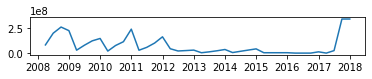

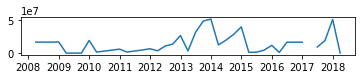

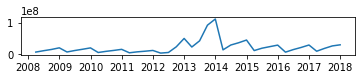

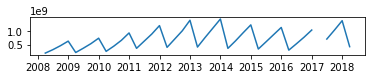

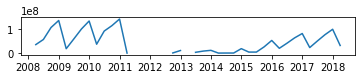

In [48]:
#在处理前，包含营收缺失值的股票代码的缺失情况
j=1
for symbol in Revenue_na:
    temp=Income[Income['TICKER_SYMBOL']==symbol]['REVENUE'].copy()
    temp=temp.interpolate()
    plt.subplot(5,1,j)
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol]['END_DATE'],Income.loc[Income['TICKER_SYMBOL']==symbol]['REVENUE'])
    j=j+1
    plt.show()
    for idx in temp.index:
        Income.loc[idx,'REVENUE']=temp.loc[idx,]

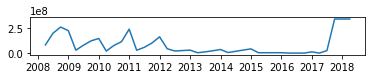

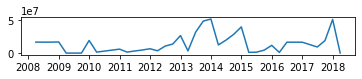

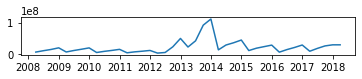

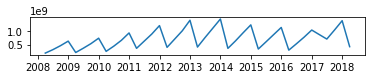

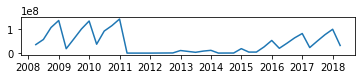

In [49]:
#在处理后，包含营收缺失值的股票代码的缺失情况
j=1
for symbol in Revenue_na:
    plt.subplot(5,1,j)
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol]['END_DATE'],Income.loc[Income['TICKER_SYMBOL']==symbol]['REVENUE'])
    j=j+1
    plt.show()

In [50]:
#继续查找其它包含缺失值的列
cols_contains_na=[]
for col in Income.columns:
    if Income[col].isnull().sum()>0:
        cols_contains_na.append(col)
print(cols_contains_na)

['COGS', 'BIZ_TAX_SURCHG', 'SELL_EXP', 'ADMIN_EXP', 'FINAN_EXP', 'ASSETS_IMPAIR_LOSS', 'INVEST_INCOME', 'NOPERATE_INCOME', 'NOPERATE_EXP', 'NCA_DISPLOSS', 'INCOME_TAX', 'MINORITY_GAIN', 'BASIC_EPS', 'T_COMPR_INCOME', 'COMPR_INC_ATTR_P', 'COMPR_INC_ATTR_M_S']


In [51]:
#将其余列缺失值用均值填充
for col in cols_contains_na:
    Income[col]=Income[col].fillna(Income[col].mean())

In [52]:
#最终查找包含空值的列
cols_contains_na=[]
for col in Income.columns:
    if Income[col].isnull().sum()>0:
        cols_contains_na.append(col)
print(cols_contains_na)

[]


In [53]:
Income.dtypes

TICKER_SYMBOL                 object
END_DATE              datetime64[ns]
REPORT_TYPE                   object
REVENUE                      float64
T_COGS                       float64
COGS                         float64
BIZ_TAX_SURCHG               float64
SELL_EXP                     float64
ADMIN_EXP                    float64
FINAN_EXP                    float64
ASSETS_IMPAIR_LOSS           float64
INVEST_INCOME                float64
OPERATE_PROFIT               float64
NOPERATE_INCOME              float64
NOPERATE_EXP                 float64
NCA_DISPLOSS                 float64
T_PROFIT                     float64
INCOME_TAX                   float64
N_INCOME                     float64
N_INCOME_ATTR_P              float64
MINORITY_GAIN                float64
BASIC_EPS                    float64
T_COMPR_INCOME               float64
COMPR_INC_ATTR_P             float64
COMPR_INC_ATTR_M_S           float64
dtype: object

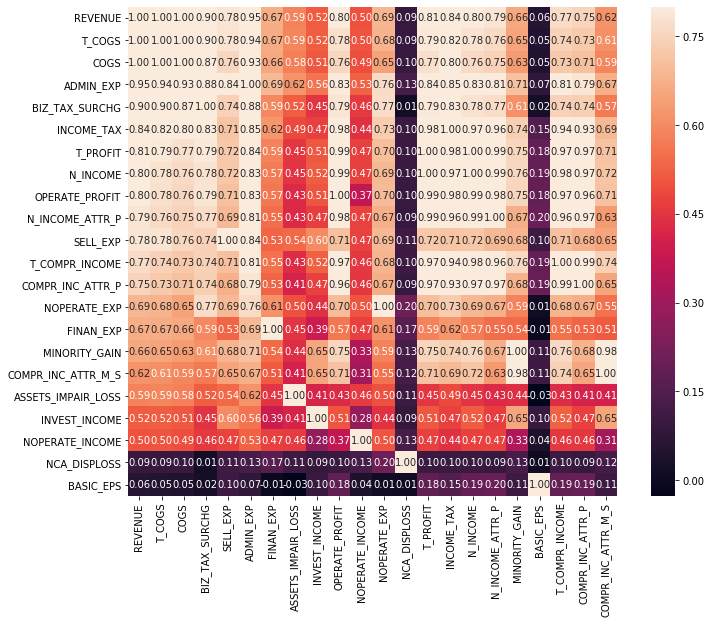

In [54]:
corrmat=Income.loc[:,'REVENUE':].corr().sort_values(by='REVENUE',ascending=False)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,annot=True, vmax=.8, fmt='.2f',square=True);

In [55]:
#改变为日期类型index
Income.index=Income['END_DATE']
Income=Income.drop('END_DATE',axis=1)
Income.head()

,TICKER_SYMBOL,REPORT_TYPE,REVENUE,T_COGS,COGS,BIZ_TAX_SURCHG,SELL_EXP,ADMIN_EXP,FINAN_EXP,ASSETS_IMPAIR_LOSS,...,NCA_DISPLOSS,T_PROFIT,INCOME_TAX,N_INCOME,N_INCOME_ATTR_P,MINORITY_GAIN,BASIC_EPS,T_COMPR_INCOME,COMPR_INC_ATTR_P,COMPR_INC_ATTR_M_S
END_DATE,,,,,,,,,,,,,,,,,,,,,
2008-03-31,000002,Q1,6.400436e+09,5.363943e+09,3.925913e+09,6.476807e+08,2.784145e+08,3.716066e+08,1.330892e+08,7.239781e+06,...,3.186763e+06,1.022828e+09,2.810980e+08,7.417298e+08,7.181333e+08,2.359653e+07,0.065,2.645500e+08,2.353865e+08,3.859405e+07
2008-06-30,000002,S1,1.725501e+10,1.394702e+10,1.017141e+10,2.039138e+09,7.091833e+08,8.167439e+08,2.007706e+08,9.768106e+06,...,3.258875e+05,3.327956e+09,1.021286e+09,2.306670e+09,2.061056e+09,2.456144e+08,0.187,2.372688e+09,2.127073e+09,2.456144e+08
2008-09-30,000002,Q3,2.254191e+10,1.887138e+10,1.341616e+10,2.480042e+09,1.133777e+09,1.003706e+09,2.728555e+08,5.648361e+08,...,9.458111e+05,3.750421e+09,1.116101e+09,2.634320e+09,2.276542e+09,3.577786e+08,0.207,2.686515e+09,2.328737e+09,3.577786e+08
2008-12-31,000002,A,4.099178e+10,3.485566e+10,2.500527e+10,4.533873e+09,1.860350e+09,1.530799e+09,6.572533e+08,1.268113e+09,...,2.336423e+06,6.322286e+09,1.682416e+09,4.639869e+09,4.033170e+09,6.066991e+08,0.370,4.679224e+09,4.072524e+09,6.066991e+08
2009-03-31,000002,Q1,8.164319e+09,6.966013e+09,5.404079e+09,8.555719e+08,2.385783e+08,2.828142e+08,1.843188e+08,6.516473e+05,...,1.159257e+05,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.070,9.188037e+08,7.990252e+08,1.197785e+08


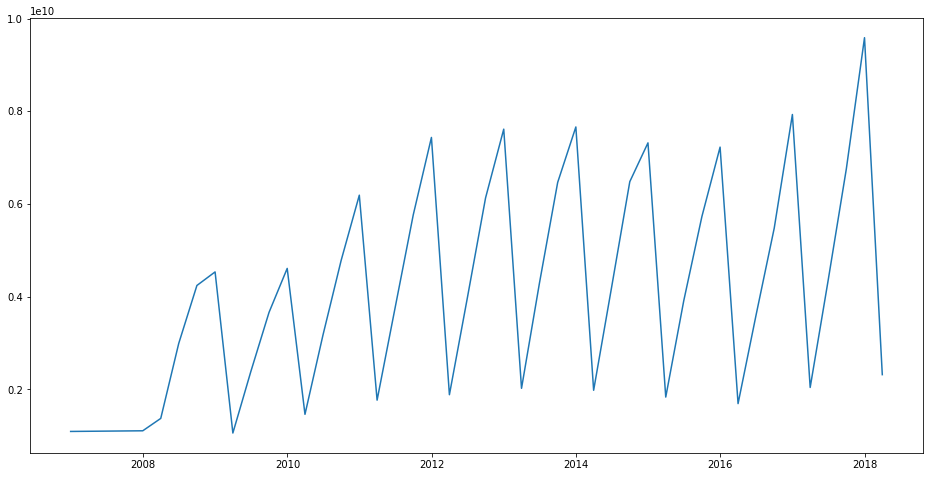

In [56]:
fig = plt.figure(figsize=(16,8))
plt.plot(Income['REVENUE'].groupby(Income.index).mean())

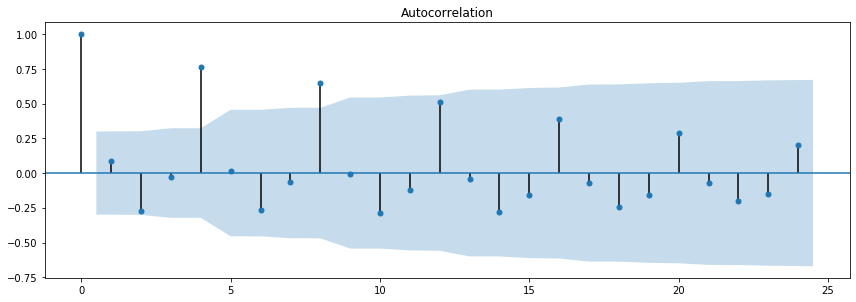

In [57]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(Income['REVENUE'].groupby(Income.index).mean(), lags=24,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

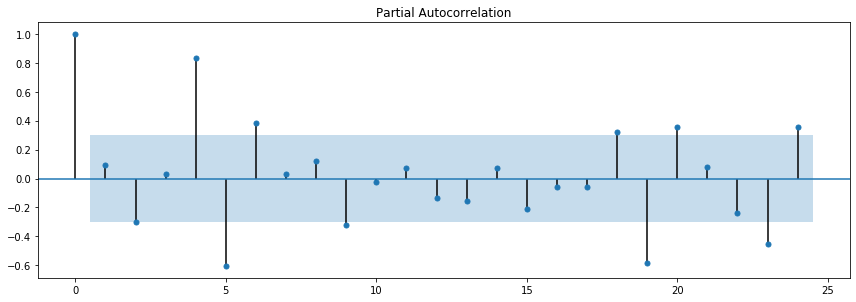

In [58]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_pacf(Income['REVENUE'].groupby(Income.index).mean(), lags=24,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [59]:
symbol_discontinuous=[]
symbol_continuous=[]
for symbol in Income['TICKER_SYMBOL'].unique():
    if (isContinuous(Income[Income['TICKER_SYMBOL']==symbol].index)==False):
        symbol_discontinuous.append(symbol)
        print ("%s的时间序列不连续"%symbol)
    else:
        symbol_continuous.append(symbol)

000333的时间序列不连续
000627的时间序列不连续
000693的时间序列不连续
000722的时间序列不连续
001965的时间序列不连续
002282的时间序列不连续
002283的时间序列不连续
002284的时间序列不连续
002285的时间序列不连续
002286的时间序列不连续
002287的时间序列不连续
002288的时间序列不连续
002289的时间序列不连续
002290的时间序列不连续
002291的时间序列不连续
002292的时间序列不连续
002293的时间序列不连续
002294的时间序列不连续
002295的时间序列不连续
002296的时间序列不连续
002297的时间序列不连续
002298的时间序列不连续
002299的时间序列不连续
002300的时间序列不连续
002301的时间序列不连续
002302的时间序列不连续
002303的时间序列不连续
002304的时间序列不连续
002305的时间序列不连续
002306的时间序列不连续
002307的时间序列不连续
002308的时间序列不连续
002309的时间序列不连续
002310的时间序列不连续
002311的时间序列不连续
002312的时间序列不连续
002313的时间序列不连续
002314的时间序列不连续
002315的时间序列不连续
002316的时间序列不连续
002317的时间序列不连续
002318的时间序列不连续
002319的时间序列不连续
002320的时间序列不连续
002321的时间序列不连续
002322的时间序列不连续
002323的时间序列不连续
002324的时间序列不连续
002325的时间序列不连续
002326的时间序列不连续
002327的时间序列不连续
002328的时间序列不连续
002329的时间序列不连续
002330的时间序列不连续
002331的时间序列不连续
002332的时间序列不连续
002333的时间序列不连续
002334的时间序列不连续
002335的时间序列不连续
002336的时间序列不连续
002337的时间序列不连续
002338的时间序列不连续
002339的时间序列不连续
002340的时间序列不连续
002341的时间序列不连续
002342的时间序列不连续
002343的时间序

002855的时间序列不连续
002856的时间序列不连续
002857的时间序列不连续
002858的时间序列不连续
002859的时间序列不连续
002860的时间序列不连续
002861的时间序列不连续
002862的时间序列不连续
002863的时间序列不连续
002864的时间序列不连续
002865的时间序列不连续
002866的时间序列不连续
002867的时间序列不连续
002868的时间序列不连续
002869的时间序列不连续
002870的时间序列不连续
002871的时间序列不连续
002872的时间序列不连续
002873的时间序列不连续
002875的时间序列不连续
002876的时间序列不连续
002877的时间序列不连续
002878的时间序列不连续
002879的时间序列不连续
002880的时间序列不连续
002881的时间序列不连续
002882的时间序列不连续
002883的时间序列不连续
002884的时间序列不连续
002885的时间序列不连续
002886的时间序列不连续
002887的时间序列不连续
002888的时间序列不连续
002889的时间序列不连续
002890的时间序列不连续
002891的时间序列不连续
002892的时间序列不连续
002893的时间序列不连续
002895的时间序列不连续
002896的时间序列不连续
002897的时间序列不连续
002898的时间序列不连续
002899的时间序列不连续
002900的时间序列不连续
002901的时间序列不连续
002902的时间序列不连续
002903的时间序列不连续
002905的时间序列不连续
002906的时间序列不连续
002907的时间序列不连续
002908的时间序列不连续
002909的时间序列不连续
002910的时间序列不连续
002911的时间序列不连续
002912的时间序列不连续
002913的时间序列不连续
002915的时间序列不连续
002916的时间序列不连续
002917的时间序列不连续
002918的时间序列不连续
002919的时间序列不连续
002920的时间序列不连续
002921的时间序列不连续
002922的时间序列不连续
002923的时间序列不连续
002925的时间序列不连续
002927的时间序

300487的时间序列不连续
300488的时间序列不连续
300489的时间序列不连续
300490的时间序列不连续
300491的时间序列不连续
300492的时间序列不连续
300493的时间序列不连续
300494的时间序列不连续
300495的时间序列不连续
300496的时间序列不连续
300497的时间序列不连续
300499的时间序列不连续
300500的时间序列不连续
300501的时间序列不连续
300502的时间序列不连续
300503的时间序列不连续
300504的时间序列不连续
300505的时间序列不连续
300506的时间序列不连续
300507的时间序列不连续
300508的时间序列不连续
300509的时间序列不连续
300510的时间序列不连续
300511的时间序列不连续
300512的时间序列不连续
300513的时间序列不连续
300514的时间序列不连续
300515的时间序列不连续
300516的时间序列不连续
300517的时间序列不连续
300518的时间序列不连续
300519的时间序列不连续
300520的时间序列不连续
300521的时间序列不连续
300522的时间序列不连续
300523的时间序列不连续
300525的时间序列不连续
300526的时间序列不连续
300527的时间序列不连续
300528的时间序列不连续
300529的时间序列不连续
300530的时间序列不连续
300531的时间序列不连续
300532的时间序列不连续
300533的时间序列不连续
300534的时间序列不连续
300535的时间序列不连续
300536的时间序列不连续
300537的时间序列不连续
300538的时间序列不连续
300539的时间序列不连续
300540的时间序列不连续
300541的时间序列不连续
300542的时间序列不连续
300543的时间序列不连续
300545的时间序列不连续
300546的时间序列不连续
300547的时间序列不连续
300548的时间序列不连续
300549的时间序列不连续
300550的时间序列不连续
300551的时间序列不连续
300552的时间序列不连续
300553的时间序列不连续
300554的时间序列不连续
300555的时间序列不连续
300556的时间序

603378的时间序列不连续
603380的时间序列不连续
603383的时间序列不连续
603385的时间序列不连续
603386的时间序列不连续
603387的时间序列不连续
603388的时间序列不连续
603389的时间序列不连续
603393的时间序列不连续
603396的时间序列不连续
603398的时间序列不连续
603399的时间序列不连续
603416的时间序列不连续
603421的时间序列不连续
603429的时间序列不连续
603444的时间序列不连续
603456的时间序列不连续
603458的时间序列不连续
603466的时间序列不连续
603477的时间序列不连续
603486的时间序列不连续
603488的时间序列不连续
603496的时间序列不连续
603499的时间序列不连续
603500的时间序列不连续
603501的时间序列不连续
603505的时间序列不连续
603506的时间序列不连续
603507的时间序列不连续
603508的时间序列不连续
603515的时间序列不连续
603516的时间序列不连续
603517的时间序列不连续
603518的时间序列不连续
603519的时间序列不连续
603520的时间序列不连续
603527的时间序列不连续
603528的时间序列不连续
603533的时间序列不连续
603535的时间序列不连续
603536的时间序列不连续
603538的时间序列不连续
603555的时间序列不连续
603556的时间序列不连续
603557的时间序列不连续
603558的时间序列不连续
603559的时间序列不连续
603566的时间序列不连续
603567的时间序列不连续
603568的时间序列不连续
603569的时间序列不连续
603577的时间序列不连续
603578的时间序列不连续
603579的时间序列不连续
603580的时间序列不连续
603585的时间序列不连续
603586的时间序列不连续
603587的时间序列不连续
603588的时间序列不连续
603589的时间序列不连续
603595的时间序列不连续
603596的时间序列不连续
603598的时间序列不连续
603599的时间序列不连续
603600的时间序列不连续
603601的时间序列不连续
603602的时间序

In [60]:
#时间序列不连续的股票代码有多少
len(symbol_discontinuous)

1911

In [61]:
len(symbol_continuous)

1584

In [62]:
dtemp=Income['REVENUE'].groupby(Income.index).mean()
model = AR(dtemp)
results_AR = model.fit()
predict_all_market = results_AR.predict(len(dtemp),len(dtemp))
predict_all_market

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


43    4.388831e+09
dtype: float64

In [68]:
#时间轴连续的个股的预测
predict_each_stock=pd.DataFrame(columns=['TICKER_SYMBOL','REVENUE'])

for symbol in symbol_continuous:
    dtemp=Income.loc[Income['TICKER_SYMBOL']==symbol]['REVENUE']
    model = AR(dtemp)
    results_AR = model.fit()
    results_AR
    predict_value = results_AR.predict(len(dtemp),len(dtemp))
    predict_each_stock=predict_each_stock.append({'REVENUE':predict_value[-1],'TICKER_SYMBOL':symbol},ignore_index=True)
    predict_each_stock


d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarn

In [65]:
predict_each_stock

,TICKER_SYMBOL,REVENUE
0,000002,6.113584e+10
1,000004,2.299009e+08
2,000005,2.219660e+08
3,000006,9.559160e+08
4,000007,2.799875e+07
5,000008,7.960274e+08
6,000009,3.216277e+09
7,000010,5.406658e+08
8,000011,7.756976e+08
9,000012,4.849364e+09


No handles with labels found to put in legend.


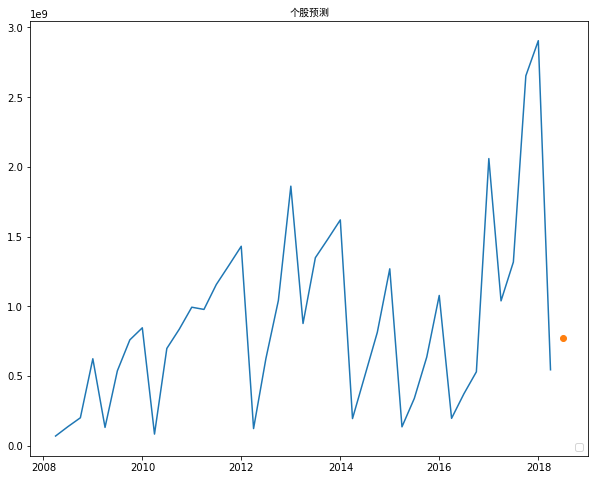

In [77]:
fig = plt.figure(figsize=(10, 8))
plt.title('个股预测',fontproperties='SimHei')
plt.plot(Income.loc[Income['TICKER_SYMBOL']=='000011']['REVENUE'].index,Income.loc[Income['TICKER_SYMBOL']=='000011']['REVENUE'])
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock.loc[predict_each_stock['TICKER_SYMBOL']=='000011']['REVENUE'],'o')
#Income['END_DATE']=pd.to_datetime(Income['END_DATE'],format='%Y-%m-%d')
#plt.plot(dtemp,'b-',label='True')
plt.legend(loc='lower right')

In [ ]:
predict.loc[predict['TICKER_SYMBOL']=='601666']['REVENUE']

In [ ]:
dtemp